In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import numpy as np

In [53]:
with open('sensitive_analysis_2G_26.pkl','r') as inputs:
    data = pickle.load(inputs)
with open('sensitive_analysis_2G_36.pkl','r') as inputs:
    data.extend(pickle.load(inputs))
with open('sensitive_analysis_2G_39.pkl','r') as inputs:
    data.extend(pickle.load(inputs))
with open('sensitive_analysis_base.pkl','r') as inputsbase:
    data_base = pickle.load(inputsbase)

In [54]:
def get_price_stat_ave(data,decision_times): #period average for each sample
    mitigation = []
    utility = []
    price = []
    a650 = []
    from tree import TreeModel 
    for i in range(len(data)): #load corresponding results
        mitigation.append(data[i][2])
        utility.append(data[i][3])
        price.append(data[i][4])
        a650.append(data[i][1][0][1])
    print(np.mean(a650))
    
    t = TreeModel(decision_times)
    nodes_index = []
    for i in range(t.num_periods):
        nodes_index.append(t.get_nodes_in_period(i)) #get nodes for slicing
    price_stat_ave = np.zeros((len(data), t.num_periods))
    for i in range(len(data)):
        for j in range(t.num_periods):
            price_stat_ave[i,j] = np.average(data[i][4][nodes_index[j][0]:nodes_index[j][1]+1])
    return price_stat_ave

def get_90_quantile(price_stat_ave):
    list0 = price_stat_ave[:,0]
    list1 = price_stat_ave[:,1]
    list2 = price_stat_ave[:,2]
    list3 = price_stat_ave[:,3]
    list4 = price_stat_ave[:,4]
    list5 = price_stat_ave[:,5]
    list_ = [list0,list1,list2,list3,list4,list5]
    for i in range(len(list_)):
        list_[i]=np.sort(list_[i])[5:95] #take the 90% of the sorted results
    list_min = []
    list_max = []
    for i in list_:
        list_min.append(i[0])
        list_max.append(i[-1])   
    return list_min,list_max #take the lower and upper bounds for the test results

In [50]:
decision_times=[0, 15, 45, 85, 185, 285, 385]
price_stat_ave= get_price_stat_ave(data,decision_times)
price_stat_ave_base =get_price_stat_ave(data_base,decision_times)

list_min,list_max = get_90_quantile(price_stat_ave)
plt.figure()
plt.plot(decision_times[:-1],list_min, 'r--')
plt.plot(decision_times[:-1],list_max,'r--')
plt.plot(decision_times[:-1],price_stat_ave_base[0,:],'b')
plt.title('Sensitivity Analysis for Variable a650', size ='xx-large')
plt.ylabel('Price in $', size = 'x-large')
plt.xlabel('Period Index', size = 'x-large')
plt.savefig('sensitivity_analysis_a650')
#plt.xlim(decision_times)

TypeError: 'DLWCost' object does not support indexing

In [55]:
def get_price_stat_ave_G(data,decision_times): #period average for each sample
    mitigation = []
    utility = []
    price = []
    a650 = []
    from tree import TreeModel 
    for i in range(len(data)): #load corresponding results
        mitigation.append(data[i][3])
        utility.append(data[i][4])
        price.append(data[i][5])
        a650.append(data[i][2])
    print(np.mean(a650))
    
    t = TreeModel(decision_times)
    nodes_index = []
    for i in range(t.num_periods):
        nodes_index.append(t.get_nodes_in_period(i)) #get nodes for slicing
    price_stat_ave = np.zeros((len(data), t.num_periods))
    for i in range(len(data)):
        for j in range(t.num_periods):
            price_stat_ave[i,j] = np.average(data[i][5][nodes_index[j][0]:nodes_index[j][1]+1])
    return price_stat_ave

def get_90_quantile(price_stat_ave):
    list0 = price_stat_ave[:,0]
    list1 = price_stat_ave[:,1]
    list2 = price_stat_ave[:,2]
    list3 = price_stat_ave[:,3]
    list4 = price_stat_ave[:,4]
    list5 = price_stat_ave[:,5]
    list_ = [list0,list1,list2,list3,list4,list5]
    for i in range(len(list_)):
        list_[i]=np.sort(list_[i])[5:95] #take the 90% of the sorted results
    list_min = []
    list_max = []
    for i in list_:
        list_min.append(i[0])
        list_max.append(i[-1])   
    return list_min,list_max #take the lower and upper bounds for the test results

95.2253335561
4.63


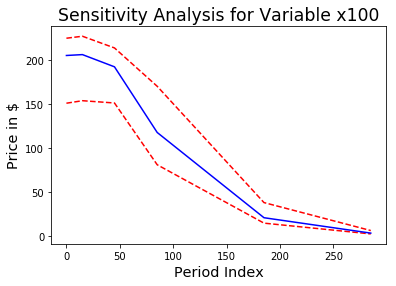

In [56]:
decision_times=[0, 15, 45, 85, 185, 285, 385]
price_stat_ave= get_price_stat_ave_G(data,decision_times)
price_stat_ave_base =get_price_stat_ave(data_base,decision_times)

list_min,list_max = get_90_quantile(price_stat_ave)
plt.figure()
plt.plot(decision_times[:-1],list_min, 'r--')
plt.plot(decision_times[:-1],list_max,'r--')
plt.plot(decision_times[:-1],price_stat_ave_base[0,:],'b')
plt.title('Sensitivity Analysis for Variable x100', size ='xx-large')
plt.ylabel('Price in $', size = 'x-large')
plt.xlabel('Period Index', size = 'x-large')
plt.savefig('sensitivity_analysis_x100')
#plt.xlim(decision_times)